# Model Training

This notebook builds a supervised macine learning classifer for the `Please tell us what you value most about this website` question from the site-wide usa.gov survey.

The learning is supervised since the models rely on $1237$ hand-labeled comments, which can be found in `labeled_data/labeled_values.xlsx`.

The best model (as identifed at the end of the notebook by the `VotingClassifer` is pickled so that it can be used on new data. That process is implemented in `CommentClassification.ipynb`

*Note*:
>Although this notebook only treats one of the four comment fields from the site-wide survey, some minor tweaking/refactoring could make it amenable to the other comment fields across both survey types. Of course, you'll need to hand label some comments first, as a I doubt these supervised models will perform well across sample groups.

*Note*:
>The grid searches do not contain extensive hyperparameter combinations. I ran those previously, inputting the best values. If you've got time - or a super fast processor - you can input a lot of hyperparamters into the param_grids and let the code run!

# Table of Contents

 - [Imports](#imports)
 - [Read in the Data](#data)
 - [Exploratory Data Analysis](#eda)
 - [Text Normalization](#text_normalization)
 - [Text Vectorization](#text_vectorization)
 - [A Naive Bayes Model](#nb)
 - [Grid Search & Cross Validation](#gridsearchcv)
 - [Voting Classifier](#voting)

<a id="imports"></a>
# Imports
Many of these packages wil require a `pip install`. A few require extra work:

#### Installing `spacy` and assets
Open your terminal and enter the following:
>`pip install spacy`<br>
`python -m spacy download en`<br>
`spacy download en_vectors_web_lg`


#### Installing `nltk` assets
After pip intalling nltk, you'll need to run these lines of code within a python interpreter (such as within this notebook). But you'll need to import nltk first.
>`nltk.download('punkt')`<br>
`nltk.download('wordnet')`<br>
`nltk.download('averaged_perceptron_tagger')`<br>
`nltk.download('stopwords')`<br>
`nltk.download('words')`

In [1]:
import math
import dill as pickle
import pandas as pd
import warnings
import re
import os
import contractions
from bs4 import BeautifulSoup
import unicodedata
from string import punctuation
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn imports
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
#in order to use SMOTE, you've got to import Pipeline from imblearn
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import SGDClassifier, LogisticRegression, PassiveAggressiveClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

#NLP imports
import gensim
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#set some options
pd.options.display.max_colwidth = 200
%matplotlib inline

<a id="data"></a>
# Read in the Data

In [2]:
labeled_comments_path = os.path.join('labeled_data','labeled_values.xlsx')
comments_df = pd.read_excel(labeled_comments_path)
#rename the column called 'Please tell us what you value most about this website.'
comments_df.rename({'Please tell us what you value most about this website.':'Value Comment'},
                   axis=1,
                   inplace=True)

In [3]:
#explicitly convert column to string
comments_df['Value Comment'] = comments_df['Value Comment'].astype(str)

<a id="eda"></a>
# Exploratory Data Analysis

## Class balance

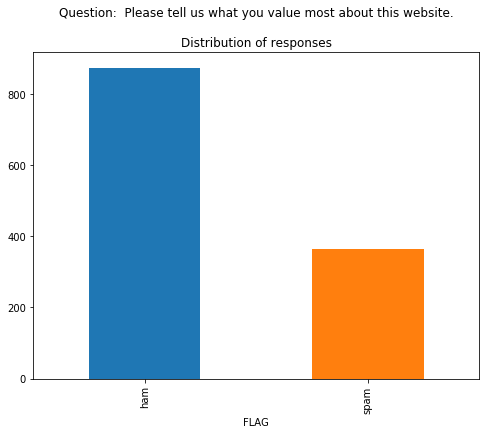

In [4]:
fig = plt.figure(figsize=(8,6))
plt.title("Question:  Please tell us what you value most about this website.\n\nDistribution of responses")
comments_df['FLAG'] = comments_df['Value FLAG'].map({0:'ham', 1:'spam'})
comments_df.groupby('FLAG')['Value Comment'].count().plot.bar(ylim=0)

### Interpretation
Slightly unbalanced classes, so consider stratified sampling for train-test-split and/or an upsampling algorithm.

## Likert data class balance

In [5]:
ordinal_cols = ["Based on today's visit, how would you rate your experience on the website overall? (Required question)",
               "How likely are you to return to USA.gov? (Required question)",
               "How likely are you to recommend this website to someone else? (Required question)",
               "Were you able to accomplish everything you wanted on USA.gov today? (Required question)"]
for i in ordinal_cols:
    print(comments_df[i].value_counts(),end="\n\n")

Good         526
Very good    440
Fair         166
Very poor     83
Poor          22
Name: Based on today's visit, how would you rate your experience on the website overall? (Required question), dtype: int64

Very likely                    613
Likely                         342
Neither likely nor unlikely    174
Very unlikely                   84
Unlikely                        24
Name: How likely are you to return to USA.gov? (Required question), dtype: int64

Very likely                    513
Likely                         333
Neither likely nor unlikely    244
Very unlikely                   97
Unlikely                        50
Name: How likely are you to recommend this website to someone else? (Required question), dtype: int64

Just browsing / not trying to accomplish anything specific    1234
Yes, fully                                                       2
No                                                               1
Name: Were you able to accomplish everything you wanted

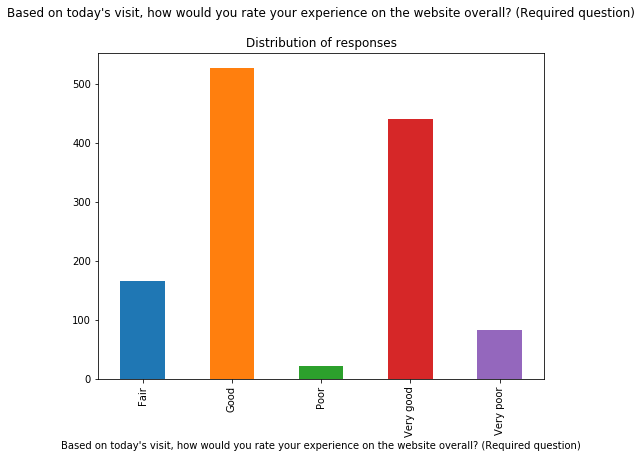

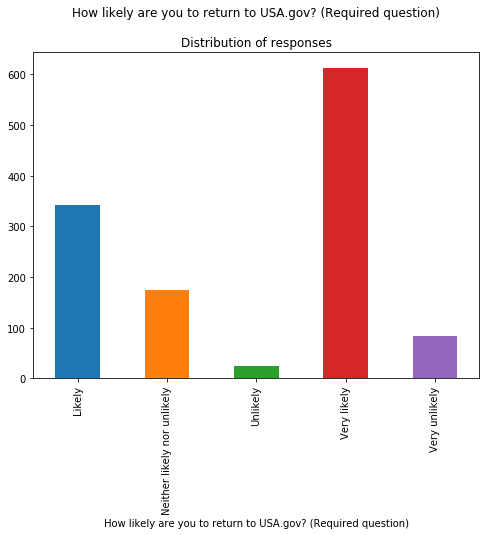

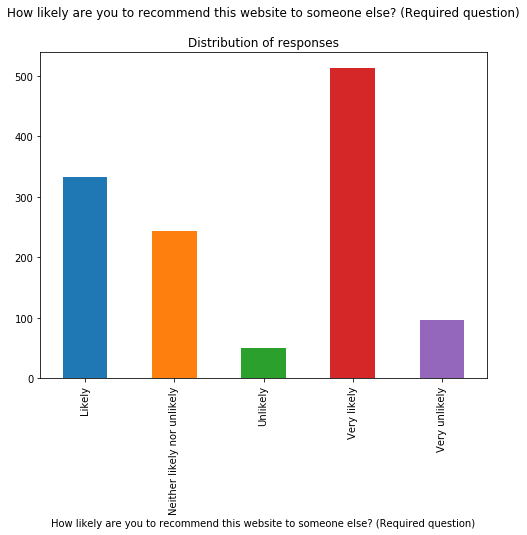

In [6]:
#plot the responses to these questions
for i in range(len(ordinal_cols)-1):
    fig = plt.figure(figsize=(8,6))
    plt.title(ordinal_cols[i]+"\n\nDistribution of responses")
    comments_df.groupby(ordinal_cols[i])[ordinal_cols[i]].count().plot.bar(ylim=0)

### Interpretation
The accomplish question has very little variability, so I'm going to drop it.

Also, I should consider converting these ordinal variables to numeric as opposed to dummy variables. This makes the assumption that there are even intervals between each response, but it saves us the trouble of wokring with sparse and dense matrices. I might also consider transforming these numerically encoded responses (e.g. squaring) so that the intervals are not evenly spaced. 

<a id="text_normalization"></a>
# Text Normalization

In [7]:
# These might need to stay global until I can figure out how to include in the sklearn Pipeline.
nlp = spacy.load('en', parse = False, tag=False, entity=False)
tokenizer = ToktokTokenizer()
stopword_list = stopwords.words('english')
#we want the negatives
stopword_list.remove('no')
stopword_list.remove('not')

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def replace_accented_chars(text):
    #The normal form KD (NFKD) will apply the compatibility decomposition, 
    #i.e. replace all compatibility characters with their equivalents (from python.org). 
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=contractions.contractions_dict):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        if contraction_mapping.get(match):
            expanded_contraction = contraction_mapping.get(match)
        else:
            expanded_contraction = contraction_mapping.get(match.lower())                    
        if expanded_contraction:
            expanded_contraction = first_char+expanded_contraction[1:]
            return expanded_contraction
        else:
            pass
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
    
def normalize_corpus(doc, html_stripping=True, contraction_expansion=True, text_lemmatization=True, 
                     stopword_removal=True):
    
    def get_profanity():
        file_path = os.path.join(os.getcwd(),"corpora","profanity.csv")
        profanity = set(pd.read_csv(file_path).values.ravel().tolist())
        return profanity

    #url regex
    url_re = re.compile(r"""(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))""")
    #email address regex
    email_re = re.compile(r'(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)')
    #phone number regex
    phone_re = re.compile(r'(?:(?:\+?1\s*(?:[.-]\s*)?)?(?:\(\s*([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9])\s*\)|([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9]))\s*(?:[.-]\s*)?)?([2-9]1[02-9]|[2-9][02-9]1|[2-9][02-9]{2})\s*(?:[.-]\s*)?([0-9]{4})(?:\s*(?:#|x\.?|ext\.?|extension)\s*(\d+))?')
    #ssn regex
    ssn_re = re.compile(r'^(?!219-09-9999|078-05-1120)(?!666|000|9\d{2})\d{3}[-]?(?!00)\d{2}[-]?(?!0{4})\d{4}$')
    #profanity regex
    profanity_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, get_profanity())))
    
    
    doc = doc.lower()
    
    doc = profanity_regex.sub("criticaster", doc)
    doc = email_re.sub('blatherskite',doc)
    doc = phone_re.sub('blatherskite',doc)
    doc = ssn_re.sub('blatherskite',doc)
    doc = url_re.sub('blatherskite',doc)
    
    # strip HTML
    if html_stripping:
        doc = strip_html_tags(doc)
    # expand contractions    
    if contraction_expansion:
        doc = expand_contractions(doc)
    # at least three characters long, cannot contain a number, and no more than 17 chars long
    doc = re.findall(r'\b[a-z][a-z][a-z]+\b',doc)
    doc = ' '.join(w for w in doc if w != 'nan' and len(w) <= 17)
    # lemmatize text
    if text_lemmatization:
        doc = lemmatize_text(doc)
    # remove stopwords
    if stopword_removal:
        doc = remove_stopwords(doc, is_lower_case=True)
    if len(doc) == 0:
        doc = "spam"    
    return doc

In [8]:
comments_df['Normalized Value Comment'] = comments_df['Value Comment'].apply(normalize_corpus)

/anaconda/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


## Inspect Results of Texts Normalization
Else garbage in, garbage out

In [2]:
# look at five parsed comments to see the effect


#random_comments = comments_df.sample(n=10, random_state = 123)
#random_comments[['Value Comment','Normalized Value Comment']]

In [3]:
## see instances of profanity being replaced

#comments_df[comments_df['Normalized Value Comment'].str.contains('criticaster')][['Value Comment','Normalized Value Comment']]

In [4]:
## see instances of ssns, urls, emails & phone numbers being being replaced with blatherskite

#comments_df[comments_df['Normalized Value Comment'].str.contains('blatherskite')][['Value Comment','Normalized Value Comment']]

In [5]:
## see instances of blanks being being replaced with spam

#comments_df[comments_df['Normalized Value Comment'].str.contains('spam')][['Value Comment','Normalized Value Comment']]

<a id="text_vectorization"></a>
# Text Vectorization
Classifier algorithms cannot directly process text. They need the words represented as numerical feature vectors with a fixed size.

We'll eventually use a variety of methods to do this, but for EDA purposes we'll use a simple yet powerful **bag of words model**: a model where for each document - a single comment in our case - the presence (and also the frequency) of words is taken into consideration, but the order in which they occur is ignored.

More specifically, for each term in our dataset, we will calculate a measure called **Term Frequency, Inverse Document Frequency**, abbreviated to tf-idf. 

>Tf-idf, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

We will use `sklearn.feature_extraction.text.TfidfVectorizer` to calculate a `tf-idf` vector for each comment. We'll use the follwing parameters:

 - `sublinear_df` is set to `True` to use a logarithmic form for frequency.
 - `min_df` is the minimum numbers of documents a word must be present in to be kept. We'll set to `5`
 - `norm` is set to `l2`, to ensure all our feature vectors have a euclidian norm of 1.
 - `ngram_range` is set to `(1, 2)` to indicate that we want to consider both unigrams and bigrams.

In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))
features = tfidf.fit_transform(comments_df['Normalized Value Comment']).toarray()
labels = comments_df['Value FLAG']
features.shape

(1237, 316)

Now, each of the $1237$ comments is represented by $316$ features. Each of these features represents the `tf-idf` score for different unigrams and bigrams.

Let's now find the terms that are the most correlated with `ham` and `spam`:

In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))
# create separate DataFrames for ham and spam
ham = comments_df[comments_df['Value FLAG']==0]
spam = comments_df[comments_df['Value FLAG']==1]
# learn the vocabulary of ALL messages and save it
tfidf.fit(comments_df['Normalized Value Comment'])
features = tfidf.get_feature_names()
# create document-term matrices for ham and spam
ham_dtm = tfidf.transform(ham['Normalized Value Comment'])
spam_dtm = tfidf.transform(spam['Normalized Value Comment'])
# count how many times EACH token appears across ALL ham messages
ham_counts = np.sum(ham_dtm.toarray(), axis=0)
# count how many times EACH token appears across ALL spam messages
spam_counts = np.sum(spam_dtm.toarray(), axis=0)
# create a DataFrame of tokens with their separate ham and spam counts
token_counts = pd.DataFrame({'token':features, 'ham':ham_counts, 'spam':spam_counts})
# add one to ham and spam counts to avoid dividing by zero (in the step that follows)
token_counts['ham'] = token_counts.ham + 1
token_counts['spam'] = token_counts.spam + 1
# calculate ratio of spam-to-ham for each token
token_counts['spam_score'] = token_counts.spam / token_counts.ham

In [15]:
# 5 least spammy words
token_counts.sort_values('spam_score').head()

,ham,spam,token,spam_score
140,86.307867,2.96158,information,0.034314
72,41.190705,1.62826,easy,0.039530
67,21.264105,1.00000,ease,0.047028
61,16.140217,1.00000,design,0.061957
184,15.066805,1.00000,navigate,0.066371


In [16]:
#5 spammiest words
token_counts.sort_values('spam_score').tail()

,ham,spam,token,spam_score
268,1.000000,4.468333,sure yet,4.468333
267,1.241105,6.937166,sure,5.589509
196,1.000000,6.906402,not sure,6.906402
197,2.175842,18.606394,nothing,8.551355
256,1.000000,39.000000,spam,39.000000


<a id="nb"></a>
# A Naive Bayes Model

Now that we have a vector representation of the text, we can train a supervised classifier to predict the `Value FLAG` given a `Normalized Value Comments`.

To to this, we'll use Mulitnomial Naive Bayes from sklearn.

#### Why Multinomial Naive Bayes?
>The multinomial naive bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). Although the multinomial distribution normally requires integer feature counts, in practice, fractional counts such as tf-idf may also work.

In [18]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 2))

X = tfidf.fit_transform(comments_df['Normalized Value Comment'])
y = comments_df['Value FLAG']
clf = MultinomialNB()
clf.fit(X, y)
y_pred = clf.predict(X)
acc = metrics.accuracy_score(y,y_pred)
print("Accuracy:  {}".format(acc))

Accuracy:  0.8577202910266775


Text(0.5,69,'Predicted')

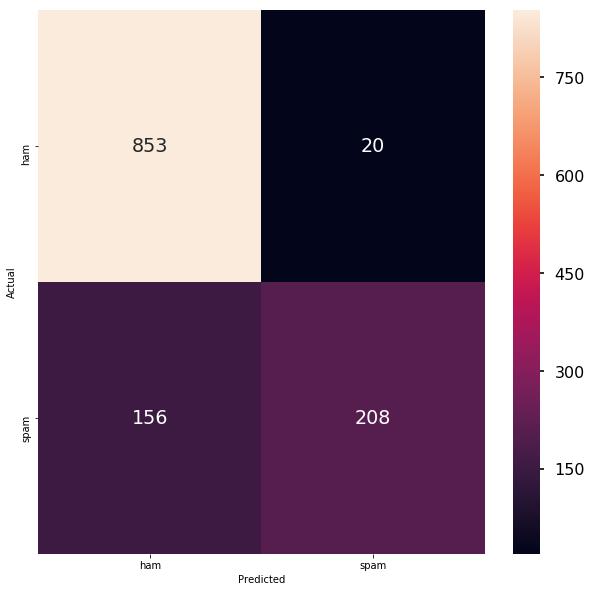

In [19]:
# Confusion Matrix
cm = metrics.confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.set_context('poster')
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [21]:
class_names = ['ham', 'spam']
print(metrics.classification_report(y, y_pred, target_names=class_names))

             precision    recall  f1-score   support

        ham       0.85      0.98      0.91       873
       spam       0.91      0.57      0.70       364

avg / total       0.87      0.86      0.85      1237



### Interpretation
The classifier did a pretty good job classifiying the ham, but it did poorly when it came to spam recall. As the confusion matrix shows, this means a lot of actual spam was predicted to be ham. This is likely due to the class imbalance. But it's better than the opposite situation where a lot of ham is classifed as spam.

It should also be noted that we trained the model on the entire dataset without using any cross-validation. This means the model is likely [overfit](http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html).

To make a better model, we'll get a little more complex...

<a id="gridsearchcv"></a>
# Grid Search & Cross Validation
Below we'll implement a **grid search**, using **cross-validation** as well as **train-test-split**, to identify the best parameters for several different classifiers. 

To do this, we'll need to creata a data transformation pipeline that:
 - **Splits the Data by Levels of Measurement**
     - Numeric Data
          - Comment Length (the `len` of the *unparsed* comment)
          - Hour, Month, Day of Year and Weekday (in [circular time](https://stats.stackexchange.com/questions/245866/is-hour-of-day-a-categorical-variable))
          - Likert questions (ordinal but converted to numeric)
     - Categorical Data
          - The page they were on (nominal), although I might drop this since it greatly increases dimensionality and the full set of pages is potentially infinite (which poses problems for one-hote encoding)
     - Text Data
          - Vectorization of the parsed comments using [word2vec](https://en.wikipedia.org/wiki/Word2vec), [glove](https://nlp.stanford.edu/projects/glove/), and [fasttext](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) using the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) values for each individual word as weights when aggregating the word-embeddings at the comment level. We'll also use the usual tf-idf without any word embeddings.
 - **Horizontally Stacks the Features**
     - The tf-idf feature set will need to be converted to a dense array prior to stacking.
 - **Standardizes the Data**
     -  When using tree-based models, we don't need to [standardize](http://scikit-learn.org/stable/modules/preprocessing.html) our values, although doing so wouldn't hurt. But if we want to use linear models, we'll need to first standardize the features. But we need to be careful with our standardization choice since the centering of sparse data destroys the sparseness. We can disable centering by passing  `with_mean=False` to the constructor of `StandardScaler`. Ideally, we'd do this only when using tf-idf to vectorize our comments.
 - **Upsamples** (optional)
     - `ADAYSN` (`ADASYN`, as opposed to `SMOTE`, will focus on the samples which are difficult to classify with a nearest-neighbors rule; this can help with the edge cases (i.e. spam that is very similiar to ham).
 - **Selects the Best Features** (optional)
     - Can use `chi2` in conjunction with `SelectKBest` to select a certain number of features from the data (cannot have negative data values for this to work, however)
 - **Evaluates Different Hyperparameter Combinations**
     - In addition to cross-validation (5 folds), we'll also train-test-split (allowing an option for `stratify_shuffle_split` since we have unbalanaced classes).
     - We'll fine-tune the following **tree-based ensemble models**:
          - `RandomForestClassifier`
          - `ExtraTreesClassifier`
          - `AdaBoostClassifier`
          - `GradientBoostingClassifier`
     - And we'll fine-tune the following **linear models**:
          - `SGDClassifier`
          - `LogisticRegression`
          - `LinearSVC`
          - `PassiveAggressiveClassifier`
     - We won't use `MultinomialNB` since that model doesn't accept negative inputs.
     - If each model performs about the same - or if a few of the models outperform the others - we'll use `VotingClassifier` to see if we can improve the **score**.
         - With unbalanced classes, it's usually advisable to use [precision-recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) as our scoring metric. The intuition is that you want to maxmimize the classifier's ability to correctly identify (precision) the most amount of spam (recall). But since the object of this project is to reduce the amount of time humans have to spend sifting through comments, we'll focus on maximizing accuracy, which will most likely minimize the number of classifications we get wrong. The fact that we're including an over-sampling algorithm as well as the option to stratify-shuffle-split further justifies the choice of accuracy as our metric. 
         
The following classes will be used as transformers within an sklearn pipeline (they inheret from BaseEstimator and TransformerMixin so the get_params() method can be called from GridsearchCV):

In [22]:
class TfidfEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within an sklearn pipeline. The pipeline will call
        the fit and transform instance methods. 
        
        The class attributes instantiate the glove, fastext, and word2vec word embedding models. 
        These models are dictionaries mapping unique words from the entire corpus (i.e. all of the Normalized 
        Value Comments) to vectors of shape [300,]. The model is chosen with __init__, which allows GridSearchCV
        to try each word embedding model (as well as the usual tf-idf).
    
    """    
    comments = comments_df['Normalized Value Comment']
    
    #### Create word2vec Model ####
    # let X_vec be a list of tokenized texts (i.e. list of lists of tokens)
    X_vec = [word_tokenize(s) for s in comments.tolist()]
    # train word2vec on the texts
    model = gensim.models.Word2Vec(X_vec, size=300, window=10, min_count=2, workers=4, iter=50)
    w2v_embedding = {w: vec for w, vec in zip(model.wv.index2word, model.wv.vectors)}

    #### Create Glove Model ####
    nlp = spacy.load('en_vectors_web_lg')
    unique_words = list(set([word for sublist in [c.split() for c in comments.tolist()] for word in sublist]))
    word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
    glove_embedding = {w: vec for w, vec in zip(unique_words, word_glove_vectors)}

    #### Create Fast Text Model ####
    # Set values for various parameters
    feature_size = 300    # Word vector dimensionality  
    window_context = 50   # Context window size                                                                                    
    min_word_count = 3    # Minimum word count                        
    sample = 1e-3         # Downsample setting for frequent words

    ft_model = gensim.models.fasttext.FastText(X_vec, size=feature_size, window=window_context, 
                                               min_count=min_word_count,sample=sample, sg=1, iter=50)
    ft_embedding = {w: vec for w, vec in zip(ft_model.wv.vocab.keys(), ft_model.wv.vectors)}
    
    
    def __init__(self, w2v="w2v"):
        """
        Description:  
            Create an instance of the class with the chosen model.
        
        Arguments:
            w2v:  a str representing the model you'd like to use to vectorize the text. Possible values:
                    'w2v': the word2vec model
                    'glove': the glove model
                    'ft': the fasttext model
                    'tf_idf':  TfidfVectorizer()
                
        """
        self.w2v = w2v
        if w2v == "w2v":
            self.model = self.w2v_embedding
            self.dim = len(next(iter(self.model.values())))
        elif w2v == "glove":
            self.model = self.glove_embedding
            self.dim = len(next(iter(self.model.values())))
        elif w2v == "ft":
            self.model = self.ft_embedding
            self.dim = len(next(iter(self.model.values())))
        else:
            self.tf_idf = None
        self.word2weight = None


    def fit(self, X_train, y=None):
        """
        Description:
            When this method is called by the sklearn pipeline, it creates the tf_idf scores for the words.
            These will be used by transform as weights when aggregating the vector representations of each
            word at the comment level.
        
        """
        if self.w2v != "tf_idf":
            # pass callable to analyzer to extract the sequence of features out of the raw, unprocessed comment.
            tfidf = TfidfVectorizer(analyzer=lambda x: x)        
            tfidf.fit(X_train)
            # if a word was never seen - it must be at least as infrequent
            # as any of the known words - so the default idf is the max of 
            # known idf's
            max_idf = max(tfidf.idf_)
            self.word2weight = defaultdict(lambda: max_idf,[(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
            return self
        else:
            self.tf_idf = TfidfVectorizer(min_df=3,
                                         max_features=None, 
                                         analyzer='word',
                                         ngram_range=(1,2),
                                         use_idf=1,
                                         smooth_idf=1,
                                         sublinear_tf=1)
            self.tf_idf.fit(X_train)
            return self


    def transform(self, X_train):        
        if self.w2v != "tf_idf":
            comments  = [[word for word in comment.split(" ")] for comment in X_train]
            embeddings =  np.array([np.mean([self.model[w] * self.word2weight[w]
                                             for w in words if w in self.model] or
                            [np.zeros(self.dim)], axis=0) for words in comments]).astype('float')
            return embeddings 
        else:
            return self.tf_idf.transform(X_train).toarray()

In [32]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within an sklearn pipeline. The pipeline will call
        the fit and transform instance methods.
        
        The transform method will simply select the columns provided to __init__.
    """
    
    
    def __init__(self, cols, dtype = 'float'):
        self.dtype = dtype
        self.cols = cols    
    
    
    def transform(self, X_train):
        col_list = []
        for c in self.cols:
            if self.dtype == 'float':
                col_list.append(X_train[c].values)
            elif self.dtype == 'str':
                col_list.append(X_train[c].astype(str))
            elif self.dtype == 'datetime':
                col_list.append(pd.to_datetime(X_train[c]))

        if len(col_list) == 1:
            return col_list[0]
        else:
            return pd.concat(col_list,axis=1)

        
    def fit(self, X_train, y=None):
        return self

In [24]:
class OrdinalTransformer(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within an sklearn pipeline. The pipeline will call
        the fit and transform instance methods.
        
        The transform method map the likert respones to numerics.
    """
    
    
    
    def __init__(self, cols):
        self.cols = cols
        
        
    def transform(self, X_train, y=None):
        if len(self.cols)>1:
            ordinal_data = []
            for col in self.cols:
                if "return" in col:
                    ret= X_train[col].map({'Very unlikely':1, 
                                           'Unlikely':2,
                                           'Neither likely nor unlikely':3,
                                           'Likely':4,
                                           'Very likely':5})
                    ordinal_data.append(ret)
                elif "recommend" in col:
                    rec = X_train[col].map({'Very unlikely':1,
                                            'Unlikely':2,
                                            'Neither likely nor unlikely':3,
                                            'Likely':4,
                                            'Very likely':5})
                    ordinal_data.append(rec)
                elif "accomplish" in col:
                    acc = X_train[col].map({'No':1,
                                            'Not yet, but still trying':2,
                                            'Just browsing / not trying to accomplish anything specific':3,
                                            'Yes, partly':4,
                                            'Yes, fully':5})
                    ordinal_data.append(acc)
                else:
                    exp = X_train[col].map({'Very poor':1,
                                            'Poor':2,
                                            'Fair':3,
                                            'Good':4,
                                            'Very good':5})
                    ordinal_data.append(exp)
            
            return pd.concat(ordinal_data,axis=1).values
        else:
            pass
    
    
    def fit(self, X_train, y=None):
        return self              
                    
            

In [25]:
class NominalEncoder(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within an sklearn pipeline. The pipeline will call
        the fit and transform instance methods.
        
        The transform method will use LabelEncoder() from sklearn to encode a nominal variable.
    """
    def __init__(self, cols):
        self.cols = cols
    
    
    def transform(self, X_train, y=None):
        
        if len(self.cols)>1:
            encoded_series = []
            for col in self.cols:
                encoder = LabelEncoder()
                encoder.fit(X_train[col])
                encoded_series.append(pd.Series(encoder.transform(X_train[col])))
            return pd.concat(encoded_series, axis=1).values
        else:
            encoder = LabelEncoder()
            encoder.fit(X_train)
            return encoder.transform(X_train).reshape(-1, 1)

        
    def fit(self, X_train, y=None):
        return self

In [26]:
class CharLengthExtractor(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within an sklearn pipeline. The pipeline will call
        the fit and transform instance methods.
        
        The transform method returns the character lengths of of each comment.
    
    """

    def __init__(self):
        pass
    def transform(self, X_train, y=None):
        #the reshape ensures that the 1D array becomes 2D"""
        return X_train.apply(lambda x: len(x)).values.reshape(-1,1).astype('float')

    
    def fit(self, X_train, y=None):
        return self

In [27]:
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    Description:
        This class is designed for use as a transformer within an sklearn pipeline. The pipeline will call
        the fit and transform instance methods.
        
        The transform method returns the datetime of each comment as ordinal cyclic variables, with each
        datetime component, e.g. the hour of the day, represnted by a trigonometric (x,y) pair of coordinates 
        from a unit cirle.
    """
    
    def __init__(self):
        pass
    
    @staticmethod
    def angular_day_of_year(unit):
        xday = math.sin(2*math.pi*unit/365)
        yday = math.cos(2*math.pi*unit/365)
        return xday, yday
    
    @staticmethod
    def angular_hour(unit):
        t = str(unit)
        (h, m, s) = t.split(':')
        result = int(h) + int(m) / 60
        xhr = math.sin(2*math.pi*result/24)
        yhr = math.cos(2*math.pi*result/24)
        return xhr, yhr
    
    @staticmethod
    def angular_month(unit):
        xmonth = math.sin(2*math.pi*unit/12)
        ymonth = math.cos(2*math.pi*unit/12)
        return xmonth, ymonth
    
    @staticmethod
    def angular_weekday(unit):
        xweekday = math.sin(2*math.pi*unit/7)
        yweekday = math.cos(2*math.pi*unit/7)
        return xweekday, yweekday
   
    def transform(self, X_train, y=None):
        hours = X_train.dt.time.apply(self.angular_hour).apply(pd.Series)
        hours.columns = ['xhr','yhr']
        weekdays = X_train.dt.weekday.apply(self.angular_weekday).apply(pd.Series)
        weekdays.columns = ['xweekday','yweekday']
        month = X_train.dt.month.apply(self.angular_month).apply(pd.Series)
        month.columns = ['xmonth','ymonth']
        day_of_year = X_train.dt.dayofyear.apply(self.angular_day_of_year).apply(pd.Series)
        day_of_year.columns = ['xday','yday']
        time_features = pd.concat([hours,month,weekdays,day_of_year],axis=1).values
        return time_features
     
    def fit(self, X_train, y=None):
        return self
        

In [48]:
#create list of ordinal and nominal cols for model
ordinal_cols = ["Based on today's visit, how would you rate your experience on the website overall? (Required question)",
               "How likely are you to return to USA.gov? (Required question)",
               "How likely are you to recommend this website to someone else? (Required question)"]

In [49]:
def grid_search(data=comments_df,
                     normalized_comment_col="Normalized Value Comment",
                     comment_col="Value Comment",
                     ordinal_cols = ordinal_cols,
                     label_col = "Value FLAG",
                     date_col = "Date",
                     stratify_shuffle_split = False,
                     scoring_metric = 'accuracy'):
    """
        Description:
            Given the survey dataset where a comment column has already been normalized, split the data into
            training and test subsets; apply custom transformers for feature extraction; and gridsearch
            the following tree-based and linear models:  RandomForestClassifier(), ExtraTreesClassifier(),
            AdaBoostClassifier(), GradientBoostingClassifier(), SGDClassifier(), LogisticRegression(),
            LinearSVC(), and PassiveAggressiveClassifier().
            
        Parameters:
            data:  the pandas dataframe containing the survey responses as well as two new columns containing
                   binary encoding of spam vs ham and the normalized comment.
            normalized_comment_col:  the str name of the normalized comment column in data.
            comment_col:  the str name of the comment column in data.
            label_col:  the str name of the column containing the class labels.
            date_col:  the str name of the datetime column in data.
            stratify_shuffle_split:  Boolean to implement stratified shuffle splitting instead of a random 
                                     train-test-split.
            scoring_metric:  The scoring metric to be used when refitting the models. 'accuracy' by default, 
                             but can also be set to 'roc_auc'.
            
        
    """
    
    X = data.drop(label_col, axis =1)
    y = data[label_col]
    
    if stratify_shuffle_split:
        #Stratified Shuffle Split ensures sample balance
        sss = StratifiedShuffleSplit(n_splits = 2, 
                                     test_size = .1, 
                                     random_state=123)
        print("Creating {} splits of the data using Stratified Shuffle Split".format(sss.get_n_splits(X, y)))
        train_indices, test_indices = next(sss.split(X, y))
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        print("Training samples:  {}\nTest samples:  {}".format(X_train.shape[0],X_test.shape[0]))
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
        

    classifiers = [RandomForestClassifier(),
                  ExtraTreesClassifier(),
                  AdaBoostClassifier(),
                  GradientBoostingClassifier(),
                  SGDClassifier(),
                  LogisticRegression(),
                  LinearSVC(),
                  PassiveAggressiveClassifier()]

    scoring = {'accuracy': metrics.make_scorer(metrics.accuracy_score),
               'roc_auc': metrics.make_scorer(metrics.roc_auc_score)}
    
    
    results = {k:[] for k in [clf.__class__.__name__ for clf in classifiers]}
    for clf in classifiers:
        print('=' * 80)
        clf_name = clf.__class__.__name__
        print("Training {}...".format(clf_name))
        print('=' * 80)
        
        pipe = Pipeline([
                         ('features', FeatureUnion([
                                     ('word2vec', Pipeline([
                                                       ('extractor', ColumnExtractor(cols=[normalized_comment_col],
                                                                                  dtype='str')),
                                                       ('vectorizer', TfidfEmbeddingVectorizer())
                                     ])),
                                     ('comment_length', Pipeline([
                                                       ('extractor',ColumnExtractor(cols=[comment_col],
                                                                                    dtype='str')),
                                                       ('num_chars', CharLengthExtractor())
                                     ])),
                                     ('ordinal', Pipeline([
                                                        ('extract', ColumnExtractor(cols = ordinal_cols,
                                                                                    dtype='str')),
                                                        ('ordinal_enc', OrdinalTransformer(cols = ordinal_cols))
                                     ])),
                                     ('datetime', Pipeline([
                                                       ('extract', ColumnExtractor(cols = [date_col],
                                                                                   dtype='datetime')),
                                                       ('date_transform', DateTransformer())
                                     ])),
                         ])),
                        ('scaler', StandardScaler(with_mean=False)),
                        ('upsample', SMOTE()),
                        ('select', SelectPercentile(f_classif)),
                        ('clf', clf)])
          
        
        if 'Random' in clf_name:
            param_grid = [
                            {'clf__max_depth': [None], 
                             'clf__max_features': ['sqrt'], 
                             'clf__min_samples_leaf': [1], 
                             'clf__min_samples_split': [2], 
                             'clf__n_estimators': [300], 
                             'features__word2vec__vectorizer__w2v': ['tf_idf'], 
                             'select': [None], 
                             'upsample': [None]}
                        ]
        
        elif "Extra" in clf_name:
            param_grid = [
                            {'clf__max_depth': [15],
                             'clf__max_features': ['sqrt'],
                             'clf__min_samples_leaf': [2],
                             'clf__min_samples_split': [2],
                             'clf__n_estimators': [500],
                             'features__word2vec__vectorizer__w2v': ['ft'],
                             'select': [SelectPercentile(percentile=50)], 
                             'upsample': [None]}
                        ]
            
        
        elif 'Gradient' in clf_name:
            param_grid = [
                            {
                              'features__word2vec__vectorizer__w2v':['ft'],
                              'upsample':[None],
                              'select': [SelectPercentile(f_classif, percentile=50)],
                              'clf__n_estimators':[300],
                              'clf__learning_rate':[.1],
                              'clf__max_depth':[5],
                              'clf__min_samples_leaf':[5],
                              'clf__min_samples_split':[2],
                              'clf__max_features':['sqrt'],
                            }
                        ]
        
        elif "AdaBoost" in clf_name:
            param_grid = [
                
                            {
                              'features__word2vec__vectorizer__w2v':['w2v'],
                              'upsample':[None],
                              'select': [None],
                              'clf__n_estimators':[800],
                              'clf__learning_rate':[.1]
                            }
                        ]
            
        elif "Linear" in clf_name:
            param_grid = [
                            {
                              'features__word2vec__vectorizer__w2v':['w2v'],
                              'upsample':[None],
                              'select': [None],
                              'clf__C':[.01],
                              'clf__class_weight':[None]
                            }
                        ]
        
        elif "Logistic" in clf_name:
            param_grid = [
                            {
                              'features__word2vec__vectorizer__w2v':['w2v'],
                              'upsample':[None],
                              'select': [None],
                              'clf__penalty':['l2'],
                              'clf__C':[10]
                            }
                        ]
        elif "SGD" in clf_name:
            param_grid = [
                            {
                              'features__word2vec__vectorizer__w2v':['w2v'],
                              'upsample':[SMOTE(kind='svm',random_state=123)],
                              'select': [SelectPercentile(f_classif, percentile=50)],
                              'clf__penalty':['l2'],
                              'clf__alpha':[1.0]
                            }
                        ]

            
        elif "Passive" in clf_name:
            param_grid = [
                            {
                              'features__word2vec__vectorizer__w2v':['tf_idf'],
                              'upsample':[None],
                              'select': [None],
                              'clf__loss':['hinge'],
                              'clf__class_weight': [None]
                            }
                        ]
            
            
        gs = GridSearchCV(pipe, param_grid = param_grid, scoring = scoring, refit = scoring_metric,
                          n_jobs = -1, verbose = True, cv = 5, return_train_score = False)
        
        gs.fit(X_train, y_train)
        best_score = gs.best_score_
        best_params = gs.best_params_
        y_pred = gs.predict(X_test)
        acc = metrics.accuracy_score(y_test,y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_pred)
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        auc = metrics.auc(precision, recall)
        average_precision = metrics.average_precision_score(y_test, y_pred)
        fbeta = metrics.fbeta_score(y_test,y_pred,beta=1.5)
        results[clf_name].append((precision, recall, average_precision, best_params, best_score))
        print("\tBest score on training data:  {0:.2f}".format(best_score))
        print("\tAccuracy on test data:  {0:.2f}".format(acc))
        print("\tFbeta on test data:  {0:.2f}".format(fbeta))
        print("\tPrecision-Recall AUC on test data:  {0:.2f}".format(auc))
        print("\tROC-AUC on test data:  {0:.2f}".format(roc_auc))
        print('-' * 80)
    
    return results

In [50]:
warnings.filterwarnings('ignore')
res = grid_search(scoring_metric='roc_auc')

Training RandomForestClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished


	Best score on training data:  0.76
	Accuracy on test data:  0.85
	Fbeta on test data:  0.71
	Precision-Recall AUC on test data:  0.49
	ROC-AUC on test data:  0.80
--------------------------------------------------------------------------------
Training ExtraTreesClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


	Best score on training data:  0.77
	Accuracy on test data:  0.88
	Fbeta on test data:  0.75
	Precision-Recall AUC on test data:  0.53
	ROC-AUC on test data:  0.83
--------------------------------------------------------------------------------
Training AdaBoostClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


	Best score on training data:  0.78
	Accuracy on test data:  0.85
	Fbeta on test data:  0.76
	Precision-Recall AUC on test data:  0.49
	ROC-AUC on test data:  0.82
--------------------------------------------------------------------------------
Training GradientBoostingClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


	Best score on training data:  0.79
	Accuracy on test data:  0.87
	Fbeta on test data:  0.77
	Precision-Recall AUC on test data:  0.51
	ROC-AUC on test data:  0.84
--------------------------------------------------------------------------------
Training SGDClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


	Best score on training data:  0.77
	Accuracy on test data:  0.65
	Fbeta on test data:  0.71
	Precision-Recall AUC on test data:  0.39
	ROC-AUC on test data:  0.72
--------------------------------------------------------------------------------
Training LogisticRegression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


	Best score on training data:  0.80
	Accuracy on test data:  0.88
	Fbeta on test data:  0.79
	Precision-Recall AUC on test data:  0.52
	ROC-AUC on test data:  0.85
--------------------------------------------------------------------------------
Training LinearSVC...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


	Best score on training data:  0.75
	Accuracy on test data:  0.89
	Fbeta on test data:  0.74
	Precision-Recall AUC on test data:  0.55
	ROC-AUC on test data:  0.83
--------------------------------------------------------------------------------
Training PassiveAggressiveClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


	Best score on training data:  0.77
	Accuracy on test data:  0.81
	Fbeta on test data:  0.61
	Precision-Recall AUC on test data:  0.42
	ROC-AUC on test data:  0.74
--------------------------------------------------------------------------------


## Interpretation

Although we're re-fitting the models based upon accuracy scores, it's important to inspect precision-recall since we're working with unbalanced classes.

### Precision-Recall Curve
A **precision-recall curve (PRC)** shows the relationship between **precision** and **recall** for every possible cut-off. 

 - **Precision**:  the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$).

 - **Recall**: the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

Basically, precision-recall is about maximizing our ability to find ham, while minimizing the spam that is inadvertently retrieved.

The PRC is a graphed with: 

 - The x-axis showing recall 
 - The y-axis showing precision
 
Thus every point on the PRC represents the trade-off between precision and recall. Ideally, the whole graph is shaded in. 

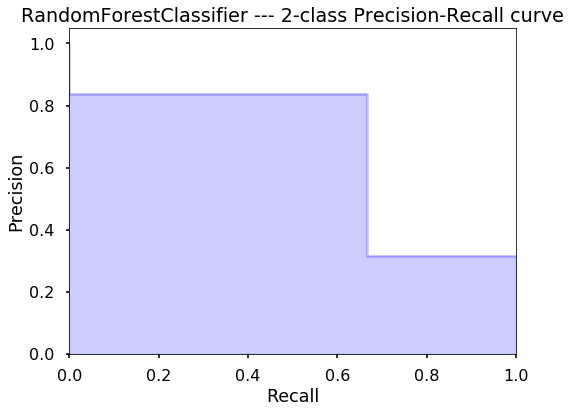

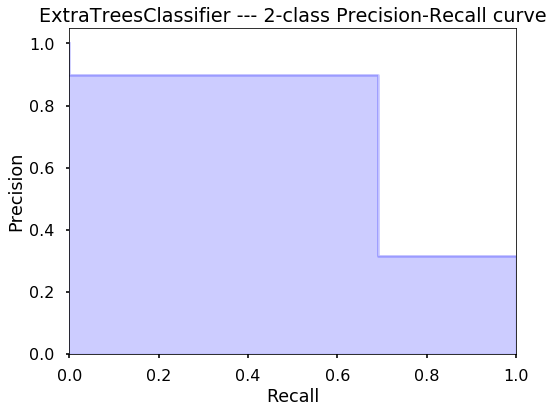

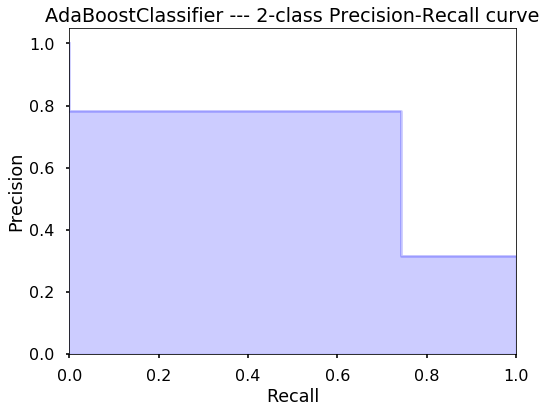

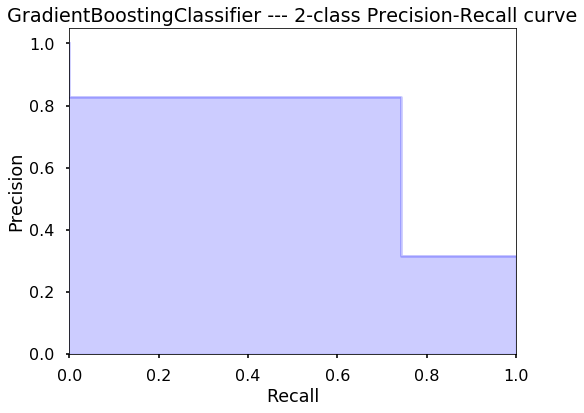

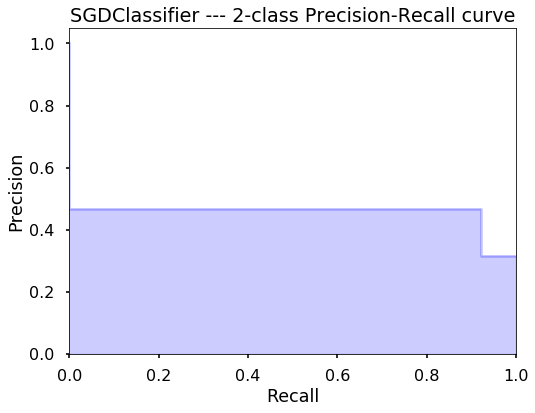

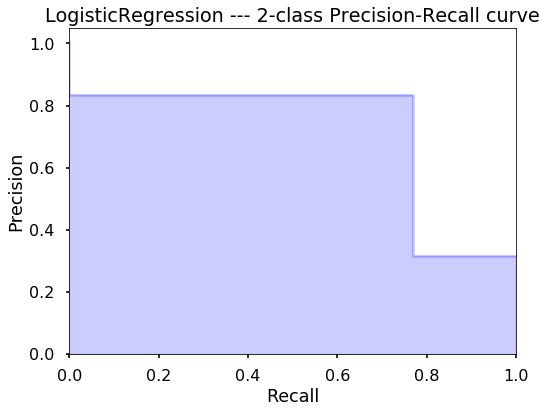

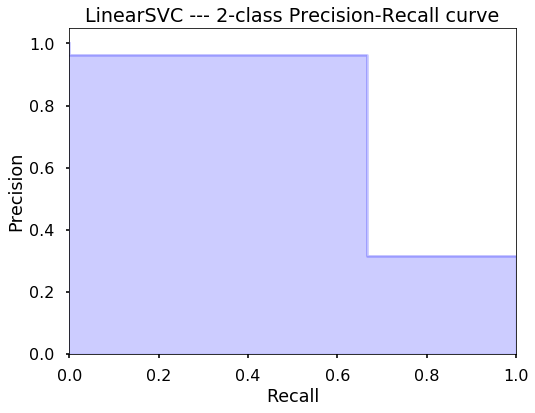

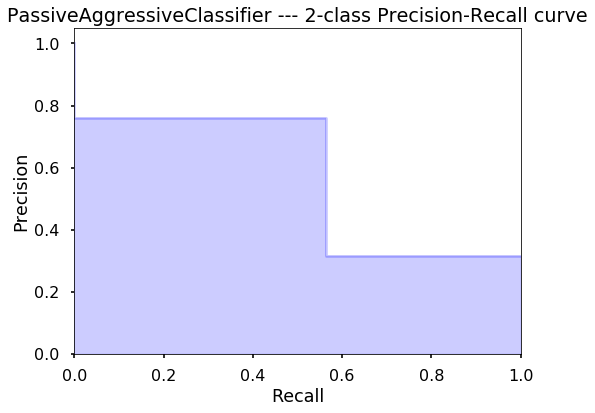

In [51]:
for k in res:
    precision, recall, average_precision, _, _ = res[k][0]
    plt.figure(figsize=(8,6))
    plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('{} --- 2-class Precision-Recall curve'.format(k))
    

<a id="voting"></a>
# Voting Classifier
Below, we'll predict the class label based on the [argmax](https://en.wikipedia.org/wiki/Arg_max) of the sums of the predicted probabilities returned by the four tree-based ensemble models.

> Ideally, this voting classifer will receive the the param_grids from the top 4 models identified in the exhaust grid search above.

In [75]:
def voting_classifier(data=comments_df,
                      parsed_text_col="Normalized Value Comment",
                      text_col="Value Comment",
                      label_col = "Value FLAG",
                      date_col = "Date",
                      ordinal_cols = ordinal_cols,
                      stratify_shuffle_split = False,
                      pickle_best_estimator = False):
    
    """
        TODO: docstring
    """
    
    X = data.drop(label_col,axis =1)
    y = data[label_col]
    
    if stratify_shuffle_split:
        #Stratified Shuffle Split to ensure sample balance
        sss = StratifiedShuffleSplit(n_splits = 2, test_size = .1, random_state=123)
        print("Creating {} splits of the data using Stratified Shuffle Split".format(sss.get_n_splits(X, y)))
        train_indices, test_indices = next(sss.split(X, y))
        for train_index, test_index in sss.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        print("Training samples:  {}\nTest samples:  {}".format(X_train.shape[0],X_test.shape[0]))
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
        

    clf1 = GradientBoostingClassifier(learning_rate=.1)
    clf2 = AdaBoostClassifier()
    clf3 = ExtraTreesClassifier()
    clf4 = RandomForestClassifier()

    eclf = VotingClassifier(estimators=[('gbc', clf1), 
                                        ('ada', clf2), 
                                        ('etc', clf3), 
                                        ('rfc', clf4)], voting='soft')

    params = {
              'features__word2vec__vectorizer__w2v':['ft','w2v','globe','tf_idf'],
              'clf__gbc__n_estimators': [100,300],
              'clf__gbc__max_depth': [4],
              'clf__gbc__min_samples_split': [10],
              'clf__gbc__learning_rate': [.1],
              'clf__gbc__max_features': ['sqrt'],
              'clf__ada__n_estimators': [100,300],
              'clf__ada__learning_rate': [.1],
              'clf__etc__n_estimators': [100,500],
              'clf__etc__max_depth': [4],
              'clf__etc__min_samples_split': [10],
              'clf__etc__max_features': ['sqrt'],
              'clf__rfc__n_estimators': [300],
              'clf__rfc__max_depth': [4],
              'clf__rfc__min_samples_leaf':[1],
              'clf__rfc__min_samples_split': [2],
              'clf__rfc__max_features': ['sqrt'],
              'upsample':[SMOTE(kind='svm'),None],
              'select': [SelectPercentile(f_classif, percentile=50),
                        SelectPercentile(f_classif, percentile=80),
                        None],
    }
            
    
    scoring = {'accuracy': metrics.make_scorer(metrics.accuracy_score)}

    pipe = Pipeline([
                     ('features', FeatureUnion([
                                 ('word2vec', Pipeline([
                                                 ('extractor',ColumnExtractor(cols=[parsed_text_col],
                                                                              dtype='str')),
                                                 ('vectorizer', TfidfEmbeddingVectorizer())
                                 ])),
                                 ('comment_length', Pipeline([
                                                   ('extractor',ColumnExtractor(cols=[text_col],
                                                                                dtype='str')),
                                                   ('num_chars', CharLengthExtractor())
                                 ])),
                                 ('ordinal', Pipeline([
                                                    ('extract', ColumnExtractor(cols = ordinal_cols,
                                                                                dtype='str')),
                                                    ('ordinal_enc', OrdinalTransformer(cols = ordinal_cols))
                                 ])),
                                 ('datetime', Pipeline([
                                                   ('extract', ColumnExtractor(cols = [date_col],
                                                                               dtype='datetime')),
                                                   ('date_transform', DateTransformer())
                                 ])),
                     ])),

                    ('scaler', StandardScaler(with_mean=False)),
                    ('upsample', SMOTE()),
                    ('select', SelectPercentile(f_classif)),
                    ('clf', eclf)])

    gs = GridSearchCV(pipe, param_grid=params, scoring = scoring, refit='accuracy',
                      n_jobs=-1, verbose=True, cv=5, return_train_score=False)
    gs.fit(X_train, y_train)
    best_score = gs.best_score_
    best_params = gs.best_params_
    y_pred = gs.predict(X_test)
    y_prob = gs.predict_proba(X_test)
    acc = metrics.accuracy_score(y_test,y_pred)
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    auc = metrics.auc(precision, recall)
    average_precision = metrics.average_precision_score(y_test, y_pred)
    fbeta = metrics.fbeta_score(y_test,y_pred,beta=1.5) 
    print("Best score on training data:  {0:.2f}".format(best_score))
    print("Accuracy on test data:  {0:.2f}".format(acc))
    print("Fbeta on test data:  {0:.2f}".format(fbeta))
    print("AUC on test data:  {0:.2f}".format(auc))
    print(best_params)
    print('=' * 80)
    if pickle_best_estimator:
        pickle_path = os.path.join('best_estimators','label_best_estimator.pkl')
        with open(pickle_path, 'wb') as f: 
            pickle.dump(gs.best_estimator_, f)  
    return (y_pred, y_prob, precision, recall, average_precision, y_test)

In [76]:
warnings.filterwarnings('ignore')
results = voting_classifier(pickle_best_estimator=False)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 63.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 103.7min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 114.5min finished


Best score on training data:  0.84
Accuracy on test data:  0.90
Fbeta on test data:  0.79
AUC on test data:  0.55
{'clf__ada__learning_rate': 0.1, 'clf__ada__n_estimators': 100, 'clf__etc__max_depth': 4, 'clf__etc__max_features': 'sqrt', 'clf__etc__min_samples_split': 10, 'clf__etc__n_estimators': 100, 'clf__gbc__learning_rate': 0.1, 'clf__gbc__max_depth': 4, 'clf__gbc__max_features': 'sqrt', 'clf__gbc__min_samples_split': 10, 'clf__gbc__n_estimators': 300, 'clf__rfc__max_depth': 4, 'clf__rfc__max_features': 'sqrt', 'clf__rfc__min_samples_split': 10, 'clf__rfc__n_estimators': 100, 'features__word2vec__vectorizer__w2v': 'w2v', 'select': SelectPercentile(percentile=50,
         score_func=<function f_classif at 0x1114e0510>), 'upsample': None}


## Precision-Recall AUC

In [111]:
y_pred, y_prob, precision, recall, average_precision, y_test = results

Text(0.5,1,'2-class Precision-Recall curve: AP=0.75')

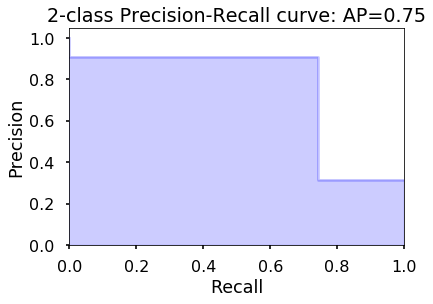

In [112]:
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

## Confusion Matrix

Text(0.5,56.3,'Predicted')

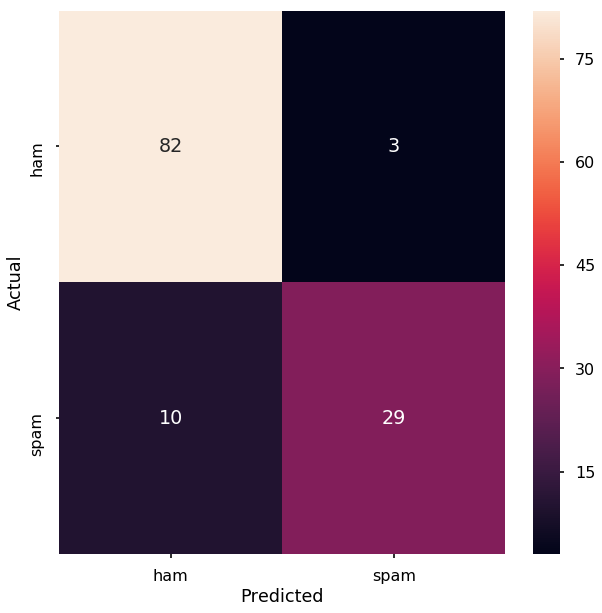

In [113]:
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.set_context('poster')
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')